<a href="https://colab.research.google.com/github/kiruthihan10/Kvasir/blob/master/Copy_of_kvasir_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d ghraycee/kvasir-dataset

100% 4.64G/4.64G [01:38<00:00, 20.7MB/s]
100% 4.64G/4.64G [01:38<00:00, 50.4MB/s]


In [0]:
! mkdir train

In [6]:
! unzip kvasir-dataset -d train


Archive:  kvasir-dataset.zip
  inflating: train/kvasir-dataset-v2/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg  
  inflating: train/kvasir-dataset-v2/dyed-lifted-polyps/007d5aa7-7289-4bad-aa4a-5c3a259e9b19.jpg  
  inflating: train/kvasir-dataset-v2/dyed-lifted-polyps/008aa3ed-1812-4854-954c-120ae85bb6bd.jpg  
  inflating: train/kvasir-dataset-v2/dyed-lifted-polyps/009171b0-52ed-4410-a1e3-410c6e746402.jpg  
  inflating: train/kvasir-dataset-v2/dyed-lifted-polyps/00cf9508-6ad1-4db9-840a-519c1d515c30.jpg  
  inflating: train/kvasir-dataset-v2/dyed-lifted-polyps/01507fbd-4d38-4525-9768-7754710f507c.jpg  
  inflating: train/kvasir-dataset-v2/dyed-lifted-polyps/018ed8ed-e489-4bbb-8a99-3346db9ec160.jpg  
  inflating: train/kvasir-dataset-v2/dyed-lifted-polyps/0195c5a6-5ddf-471c-9868-2ea66b81f440.jpg  
  inflating: train/kvasir-dataset-v2/dyed-lifted-polyps/01d38b8f-74b2-4147-9519-448d05bf8745.jpg  
  inflating: train/kvasir-dataset-v2/dyed-lifted-polyps/024c97aa-caf1-4bc9-92d6-

In [7]:
%tensorflow_version 2.x


TensorFlow 2.x selected.


In [8]:
import tensorflow as tf
import os
import numpy
from tensorflow import keras
tf.__version__

'2.1.0-rc1'

In [0]:
base_dir = os.path.join('','/content/train/kvasir-dataset-v2/')
import shutil
shutil.rmtree('/content/train/kvasir-dataset-v2/kvasir-dataset-v2', ignore_errors=True)

In [10]:
image_size = 299

batch_size = 128

image_dataset = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)

# Flow training images in batches of 20 using train_datagen generator
train_generator = image_dataset.flow_from_directory(
                base_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='sparse',
                subset='training',
                seed = 52)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = image_dataset.flow_from_directory(
                base_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='sparse',
                subset='validation',
                seed = 52)



Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


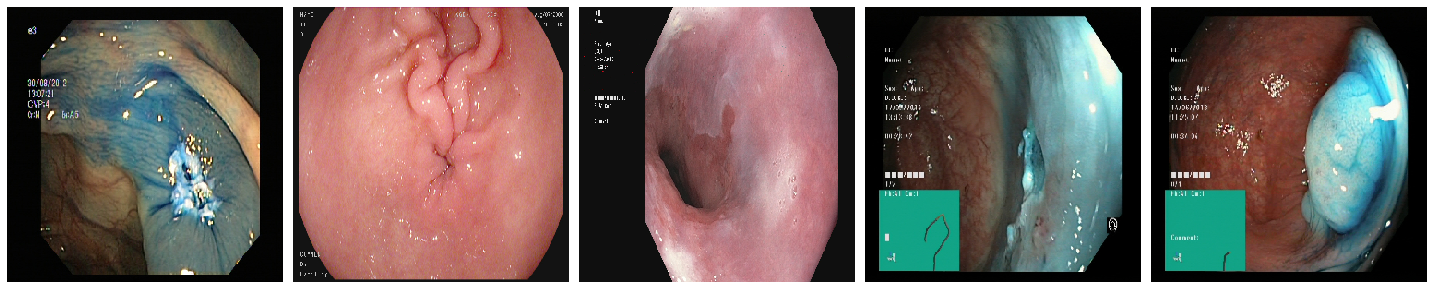

(128,)


In [11]:
sample_training_images, _ = next(train_generator)
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])
print(_.shape)

In [12]:
IMG_SHAPE = (image_size, image_size,3)

base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=IMG_SHAPE,
                                            include_top = False,                                              
                                               weights='imagenet')

219062272/219055592 [==============================] - 9s 0us/step


In [0]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [0]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(axis=1 , center=True , scale=True),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation='relu',),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(axis=1 , center=True , scale=True),
    keras.layers.Dense(32,activation='relu',),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(axis=1,center=True,scale=True),
    keras.layers.Dense(8,activation='softmax')
])

In [0]:
initial_learning_rate = 0.05
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.99,
    staircase=True)

In [0]:
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule,clipvalue=0.5)

In [0]:
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 98304)             0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 98304)             393216    
_________________________________________________________________
dense (Dense)                (None, 512)               50332160  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [20]:
epochs = 14
steps_per_epoch = train_generator.n//batch_size
validation_steps = validation_generator.n//batch_size
history = model.fit_generator(train_generator,
                             steps_per_epoch = steps_per_epoch,
                             epochs = epochs,
                             workers = 4,
                             validation_data = validation_generator,
                             validation_steps = validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 12 steps
Epoch 1/14
50/50 [==============================] - 102s 2s/step - loss: 1.5977 - acc: 0.3258 - val_loss: 1.8372 - val_acc: 0.3398
Epoch 2/14
50/50 [==============================] - 85s 2s/step - loss: 1.2998 - acc: 0.4366 - val_loss: 1.5895 - val_acc: 0.4740
Epoch 3/14
50/50 [==============================] - 85s 2s/step - loss: 1.1183 - acc: 0.5067 - val_loss: 1.1352 - val_acc: 0.5560
Epoch 4/14
50/50 [==============================] - 85s 2s/step - loss: 0.9633 - acc: 0.5697 - val_loss: 1.1943 - val_acc: 0.5482
Epoch 5/14
50/50 [==============================] - 87s 2s/step - loss: 0.8173 - acc: 0.6208 - val_loss: 1.1584 - val_acc: 0.5905
Epoch 6/14
50/50 [==============================] - 86s 2s/step - loss: 0.7115 - acc: 0.6681 - val_loss: 1.3258 - val_acc: 0.5527
Epoch 7/14
50/50 [==============================] -

In [21]:
tf.saved_model.save(model, "/tmp/mobilenet/1/")

KeyboardInterrupt: ignored

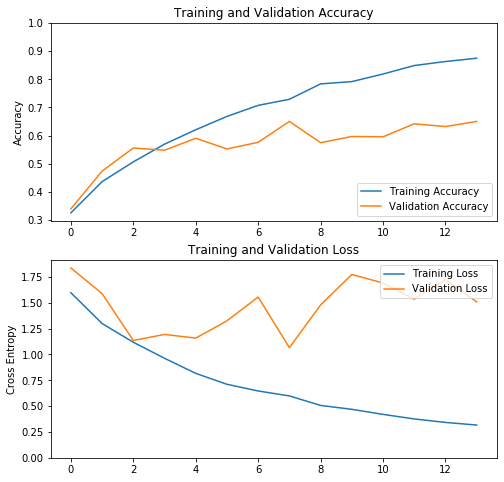

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [0]:
image_size = 299

batch_size = 16

image_dataset = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2,brightness_range=(0.4, 0.9),zoom_range=[1, 1.5],horizontal_flip=True)

# Flow training images in batches of 20 using train_datagen generator
train_generator = image_dataset.flow_from_directory(
                base_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='sparse',
                subset='training',
                seed = 52)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = image_dataset.flow_from_directory(
                base_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='sparse',
                subset='validation',
                seed = 52)



In [0]:
base_model.trainable = True
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule,clipvalue=0.5)
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])
model.summary()
epochs = history.epoch[-1]+10
steps_per_epoch = train_generator.n//batch_size
validation_steps = validation_generator.n//batch_size
print(validation_steps)
print(steps_per_epoch)
history = model.fit_generator(train_generator,
                             steps_per_epoch = steps_per_epoch,
                             initial_epoch =  history.epoch[-1],
                             epochs = epochs,
                             workers = 4,
                             validation_data = validation_generator,
                             validation_steps = validation_steps)

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
model.save('my_model_1.h5')